# LayoutLM applied to FUNSD dataset

Main reference: https://github.com/philschmid/document-ai-transformers/blob/main/training/layoutlm_funsd.ipynb

## Setup Environment

Our first step is to install the Hugging Face Libraries, including transformers and datasets. Running the following cell will install all the required packages. Additinoally, we need to install an OCR-library to extract text from images. We will use pytesseract.

In [ ]:
# ubuntu
!sudo apt install -y tesseract-ocr
# python
!pip install pytesseract transformers datasets seqeval tensorboard evaluate tesseract
# install git-fls for pushing model and logs to the hugging face hub
!sudo apt-get install git-lfs --yes

First we login into <code>huggingface_hub</code> and declare our access token. This will be useful later on when we fine-tune our pre-trained model.

In [1]:
from huggingface_hub import notebook_login
notebook_login()

access_token = "YOUR_PERSONAL_ACCESS_TOKEN"

We will use the FUNSD dataset a collection of 199 fully annotated forms. The dataset is available on Hugging Face at <code>nielsr/funsd</code>.

The LayoutLM model doesn't have a <code>AutoProcessor</code> to nice create the our input documents, but we can use the <code>LayoutLMv2Processor</code> instead.

In [3]:
processor_id="microsoft/layoutlmv2-base-uncased"
dataset_id ="nielsr/funsd"

## Load and prepare FUNSD dataset

To load the funsd dataset, we use the <code>load_dataset()</code> method from the 🤗 Datasets library.

In [4]:
from datasets import load_dataset


dataset = load_dataset(dataset_id)

print(f"Train dataset size: {len(dataset['train'])}")
print(f"Test dataset size: {len(dataset['test'])}")


Found cached dataset funsd (/Users/pmorelr/.cache/huggingface/datasets/nielsr___funsd/funsd/1.0.0/8b0472b536a2dcb975d59a4fb9d6fea4e6a1abe260b7fed6f75301e168cbe595)


  0%|          | 0/2 [00:00<?, ?it/s]

Train dataset size: 149
Test dataset size: 50


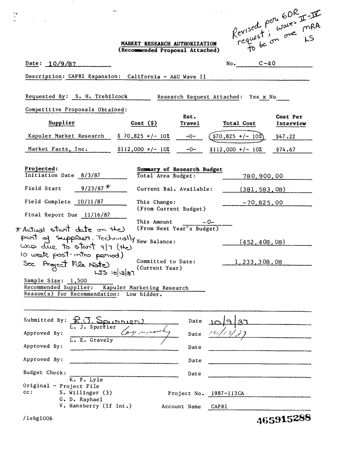

In [7]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open(dataset['train'][32]['image_path'])
image = image.convert("RGB")
image.resize((350,450))

We can display all our classes by inspecting the features of our dataset. Those <code>ner_tags</code> will be later used to create a user friendly output after we fine-tuned our model.

In [8]:
labels = dataset['train'].features['ner_tags'].feature.names
print(f"Available labels: {labels}")

id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}

Available labels: ['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER']


To train our model we need to convert our inputs (text/image) to token IDs. This is done by a 🤗 Transformers Tokenizer and PyTesseract.

In [9]:
from transformers import LayoutLMv2Processor

processor = LayoutLMv2Processor.from_pretrained(processor_id, apply_ocr=False)

Before we can process our dataset we need to define the <code>features</code> or the processed inputs, which are later based into the model. Features are a special dictionary that defines the internal structure of a dataset. Compared to traditional NLP datasets we need to add the <code>bbox</code> feature, which is a 2D array of the bounding boxes for each token.

In [10]:
from PIL import Image
from functools import partial
from datasets import Features, Sequence, ClassLabel, Value, Array2D


# we need to define custom features
features = Features(
    {
        "input_ids": Sequence(feature=Value(dtype="int64")),
        "attention_mask": Sequence(Value(dtype="int64")),
        "token_type_ids": Sequence(Value(dtype="int64")),
        "bbox": Array2D(dtype="int64", shape=(512, 4)),
        "labels": Sequence(ClassLabel(names=labels)),
    }
)

In [11]:
# preprocess function to perpare into the correct format for the model
def process(sample, processor=None):
    encoding = processor(
        Image.open(sample["image_path"]).convert("RGB"),
        sample["words"],
        boxes=sample["bboxes"],
        word_labels=sample["ner_tags"],
        padding="max_length",
        truncation=True,
    )
    del encoding["image"]
    return encoding

In [12]:
# process the dataset and format it to pytorch
proc_dataset = dataset.map(
    partial(process, processor=processor),
    remove_columns=["image_path", "words", "ner_tags", "id", "bboxes"],
    features=features,
).with_format("torch")

print(proc_dataset["train"].features.keys())

Loading cached processed dataset at /Users/pmorelr/.cache/huggingface/datasets/nielsr___funsd/funsd/1.0.0/8b0472b536a2dcb975d59a4fb9d6fea4e6a1abe260b7fed6f75301e168cbe595/cache-37d459d0648189a6.arrow


  0%|          | 0/50 [00:00<?, ?ex/s]

dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'bbox', 'labels'])


## Fine-tune and evaluate LayoutLM

After we have processed our dataset, we can start training our model. Therefore we first need to load the <code>microsoft/layoutlm-base-uncased</code> model with the <code>LayoutLMForTokenClassification</code> class with the label mapping of our dataset.

In [13]:
from transformers import LayoutLMForTokenClassification

model_id = "microsoft/layoutlm-base-uncased"

In [15]:
model = LayoutLMForTokenClassification.from_pretrained(
    model_id, num_labels=len(labels), label2id=label2id, id2label=id2label, use_auth_token=access_token
)

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft

We want to evaluate our model during training. The <code>Trainer</code> supports evaluation during training by providing a <code>compute_metrics</code>. We are going to use <code>seqeval</code> and the evaluate library to evaluate the overall f1 score for all tokens.

In [17]:
import evaluate
import numpy as np

# load seqeval metric
metric = evaluate.load("seqeval")

# labels of the model
ner_labels = list(model.config.id2label.values())


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    all_predictions = []
    all_labels = []
    for prediction, label in zip(predictions, labels):
        for predicted_idx, label_idx in zip(prediction, label):
            if label_idx == -100:
                continue
            all_predictions.append(ner_labels[predicted_idx])
            all_labels.append(ner_labels[label_idx])
    return metric.compute(predictions=[all_predictions], references=[all_labels])



The last step is to define the hyperparameters (<code>TrainingArguments</code>) we want to use for our training. We are leveraging the Hugging Face Hub integration of the <code>Trainer</code> to automatically push our checkpoints, logs and metrics during training into a repository.

In [18]:
from huggingface_hub import HfFolder
from transformers import Trainer, TrainingArguments
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# hugging face parameter
repository_id = "layoutlm-funsd"

# Define training args
training_args = TrainingArguments(
    output_dir=repository_id,
    num_train_epochs=15,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    fp16=False,
    learning_rate=3e-5,
    # logging & evaluation strategies
    logging_dir=f"{repository_id}/logs",
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="overall_f1",
    # push to hub parameters
    report_to="tensorboard",
    push_to_hub=True,
    hub_strategy="every_save",
    hub_model_id=repository_id,
    hub_token=HfFolder.get_token(),
)

# Create Trainer instance

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=proc_dataset["train"],
    eval_dataset=proc_dataset["test"],
    compute_metrics=compute_metrics,
)

'\ntrainer = Trainer(\n    model=model2,\n    args=training_args,\n    train_dataset=proc_dataset["train"],\n    eval_dataset=proc_dataset["test"],\n    compute_metrics=compute_metrics,\n)\n'

We can start our training by using the train method of the <code>Trainer</code>.

In [ ]:
# Start training
trainer.train()

After our training is done we also want to save our processor to the Hugging Face Hub and create a model card.

In [44]:
# change apply_ocr to True to use the ocr text for inference
processor.feature_extractor.apply_ocr = True

# Save processor and create model card
processor.save_pretrained(repository_id)
trainer.create_model_card()
trainer.push_to_hub()

Image processor saved in layoutlm-funsd/preprocessor_config.json
tokenizer config file saved in layoutlm-funsd/tokenizer_config.json
Special tokens file saved in layoutlm-funsd/special_tokens_map.json
Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Token Classification', 'type': 'token-classification'}, 'dataset': {'name': 'funsd', 'type': 'funsd', 'config': 'funsd', 'split': 'train', 'args': 'funsd'}}
Saving model checkpoint to layoutlm-funsd
Configuration saved in layoutlm-funsd/config.json
Model weights saved in layoutlm-funsd/pytorch_model.bin


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Upload file pytorch_model.bin:   0%|          | 32.0k/430M [00:00<?, ?B/s]

Upload file logs/events.out.tfevents.1673446845.Pedros-MacBook-Air.local.66883.0: 100%|##########| 13.8k/13.8k…

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/pmorelr/layoutlm-funsd
   aac3e47..94da155  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Token Classification', 'type': 'token-classification'}, 'dataset': {'name': 'funsd', 'type': 'funsd', 'config': 'funsd', 'split': 'train', 'args': 'funsd'}}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'https://huggingface.co/pmorelr/layoutlm-funsd/commit/94da155da13097b46638c2889799a5fa1bd5735c'

## Run inference and parse form

Now we have a trained model, we can use it to run inference. We will create a function that takes a document image and returns the extracted text and the bounding boxes.

In [22]:
from transformers import LayoutLMForTokenClassification, LayoutLMv2Processor
from PIL import Image, ImageDraw, ImageFont
import torch

# load model and processor from huggingface hub
model = LayoutLMForTokenClassification.from_pretrained("philschmid/layoutlm-funsd")
processor = LayoutLMv2Processor.from_pretrained("philschmid/layoutlm-funsd")


# helper function to unnormalize bboxes for drawing onto the image
def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]


label2color = {
    "B-HEADER": "blue",
    "B-QUESTION": "red",
    "B-ANSWER": "green",
    "I-HEADER": "blue",
    "I-QUESTION": "red",
    "I-ANSWER": "green",
}

# draw results onto the image
def draw_boxes(image, boxes, predictions):
    width, height = image.size
    normalizes_boxes = [unnormalize_box(box, width, height) for box in boxes]

    # draw predictions over the image
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    for prediction, box in zip(predictions, normalizes_boxes):
        if prediction == "O":
            continue
        draw.rectangle(box, outline="black")
        draw.rectangle(box, outline=label2color[prediction])
        draw.text((box[0] + 10, box[1] - 10), text=prediction, fill=label2color[prediction], font=font)
    return image


# run inference
def run_inference(path, model=model, processor=processor, output_image=True):
    # create model input
    image = Image.open(path).convert("RGB")
    encoding = processor(image, return_tensors="pt")
    del encoding["image"]
    # run inference
    outputs = model(**encoding)
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    # get labels
    labels = [model.config.id2label[prediction] for prediction in predictions]
    if output_image:
        return draw_boxes(image, encoding["bbox"][0], labels)
    else:
        return labels



loading configuration file config.json from cache at /Users/pmorelr/.cache/huggingface/hub/models--philschmid--layoutlm-funsd/snapshots/5dc97b05b27e5efed5f331a2216726dd7b338e43/config.json
Model config LayoutLMConfig {
  "_name_or_path": "microsoft/layoutlm-base-uncased",
  "architectures": [
    "LayoutLMForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-HEADER",
    "2": "I-HEADER",
    "3": "B-QUESTION",
    "4": "I-QUESTION",
    "5": "B-ANSWER",
    "6": "I-ANSWER"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-ANSWER": 5,
    "B-HEADER": 1,
    "B-QUESTION": 3,
    "I-ANSWER": 6,
    "I-HEADER": 2,
    "I-QUESTION": 4,
    "O": 0
  },
  "layer_norm_eps": 1e-12,
  "max_2d_position_embeddings": 1024,
  "max_position_embeddings": 512,
  "model_type": "layoutlm",
  "num_attention_hea

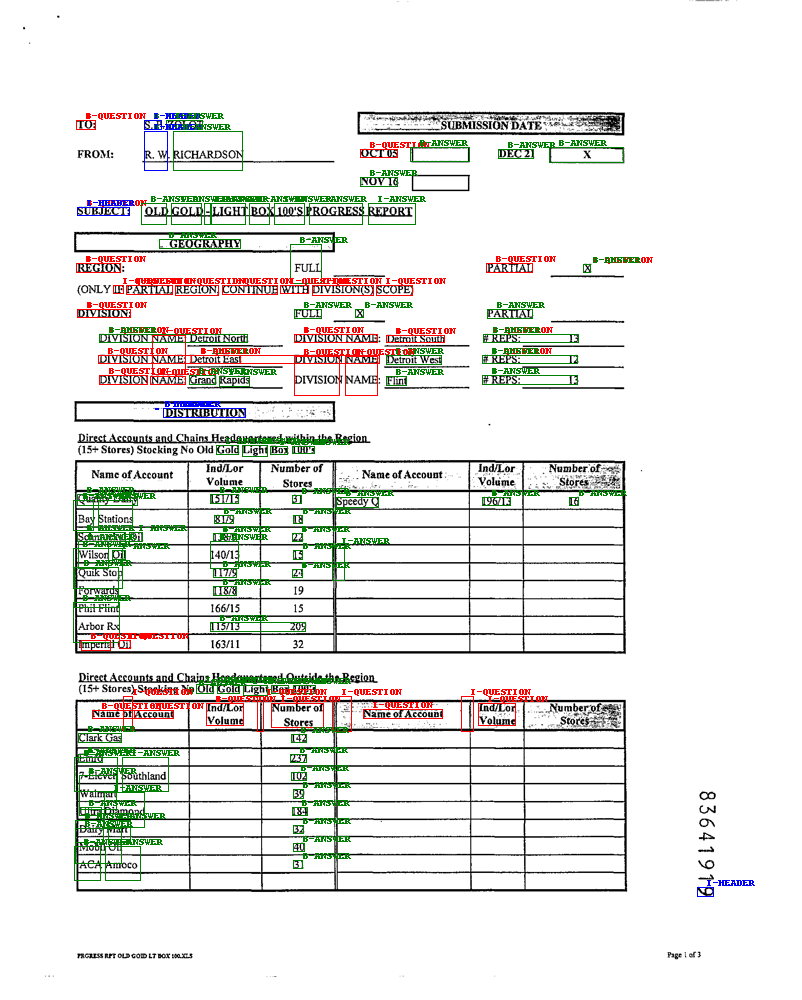

In [27]:
run_inference(dataset["test"][20]["image_path"])